# Architecture experiments

### Imports

In [24]:
from MLP import MLP
from MLP.loss import MSE, CROSSENTROPY
from MLP.activation import Activation
from MLP.initialization import WeightInitialization
from sklearn.model_selection import train_test_split
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Data preparation

In [47]:
test_size = 6000
train_size = 1000
weight_initialization = WeightInitialization.HE
random_seeds = [1234, 4321, 2021]
activation_function = Activation.TANH
loss_function = CROSSENTROPY
reg_L1 = 0
reg_L2 = 0
batch_size = 30
epochs = 100
learning_rate = 1e-2
momentum = 0.9

df: pd.DataFrame = pd.read_csv("data/train.csv");
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Experiment functions definition

In [42]:
def testdata_MLP_classification(data_m: np.ndarray,
                                target_m: np.ndarray,
                                test_size: int,
                                train_size:int,
                                hidden_layers: List[int],
                                weight_initialization: WeightInitialization,
                                random_seed: int,
                                activation_functions: List[Activation],
                                loss_function,
                                reg_L1: float,
                                reg_L2: float,
                                batch_size: int,
                                epochs: int,
                                learning_rate: float,
                                momentum: float,
                                show_plots: bool) -> Tuple[np.ndarray, np.ndarray]:

    data, test, y_train, y_test = train_test_split(data_m, target_m,
                                                   test_size=test_size,
                                                   train_size=train_size,
                                                   random_state=random_seed)

    data_max = np.max(data)

    data = data / data_max
    test = test / data_max

    # one hot encoding
    n_values = np.max(y_train) + 1
    target = np.eye(n_values)[y_train]
    test_target = np.eye(n_values)[y_test]

    mlp = MLP(data,
              target,
              hidden_layers=hidden_layers,
              weight_initialization=weight_initialization,
              random_seed=random_seed,
              activation_functions=activation_functions,
              problem_type=MLP.ProblemType.CLASSIFICATION,
              loss_function=loss_function)

    mlp.fit(reg_L1=reg_L1,
            reg_L2=reg_L2,
            batch_size=batch_size,
            epochs=epochs,
            learning_rate=learning_rate,
            momentum=momentum,
            test_data=test,
            test_target=test_target)

    y_test_predict = mlp.predict(test)
    accuracy = np.mean(y_test_predict == y_test)

    print(f"Classification accuracy: {np.mean(y_test_predict == y_test)}\n")

    if show_plots:
        mlp.visualize_architecture()
        mlp.scatter_classification(y_test, test)
        mlp.print_loss_by_epoch()
        plt.show()

    return mlp.loss_values, mlp.test_loss_values, mlp

### Experiment data

In [27]:
architectures = [
    [32],
    [32, 32],
    [32, 32, 32],
    [64],
    [64, 64],
    [64, 64, 64],
    [128],
    [128, 128, 128],
    [128, 64],
    [128, 64, 64],
    [128, 64, 32]
]

### Experiments

In [52]:
for hidden_layers in architectures:
    for random_seed in random_seeds:
        loss_values, loss_test_values, model =\
            testdata_MLP_classification(data_m=df.loc[:, df.columns != "label"].to_numpy(),
                                        target_m=df["label"].to_numpy(),
                                        test_size=test_size,
                                        train_size=train_size,
                                        hidden_layers=hidden_layers,
                                        weight_initialization=weight_initialization,
                                        random_seed=random_seed,
                                        activation_functions=[activation_function]*len(hidden_layers) + [Activation.SOFTMAX],
                                        loss_function=CROSSENTROPY,
                                        reg_L1=0,
                                        reg_L2=0,
                                        batch_size=batch_size,
                                        epochs=epochs,
                                        learning_rate=learning_rate,
                                        momentum=momentum,
                                        show_plots=False)

  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8748333333333334



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8788333333333334



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8888333333333334



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8795



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8756666666666667



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8846666666666667



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8753333333333333



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.873



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8848333333333334



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8748333333333334



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8791666666666667



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8915



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8721666666666666



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.879



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8881666666666667



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.876



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8843333333333333



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8896666666666667



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8766666666666667



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8788333333333334



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8846666666666667



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8815



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8803333333333333



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8901666666666667



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8793333333333333



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8831666666666667



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8906666666666667



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8776666666666667



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.883



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.891



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8813333333333333



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8816666666666667



100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Classification accuracy: 0.892



In [44]:
a, b, c = testdata_MLP_classification(data_m=df.loc[:, df.columns != "label"].to_numpy(),
                                      target_m=df["label"].to_numpy(),
                                      test_size=40000,
                                      train_size=2000,
                                      hidden_layers=[128, 64, 32],
                                      weight_initialization=weight_initialization,
                                      random_seed=random_seed,
                                      activation_functions=[activation_function]*len(hidden_layers) + [Activation.SOFTMAX],
                                      loss_function=CROSSENTROPY,
                                      reg_L1=0,
                                      reg_L2=0,
                                      batch_size=batch_size,
                                      epochs=1000,
                                      learning_rate=1e-4,
                                      momentum=momentum,
                                      show_plots=False)

100%|██████████| 1000/1000 [10:41<00:00,  1.56it/s]


Classification accuracy: 0.8997



In [45]:
d, e, f = testdata_MLP_classification(data_m=df.loc[:, df.columns != "label"].to_numpy(),
                                      target_m=df["label"].to_numpy(),
                                      test_size=40000,
                                      train_size=2000,
                                      hidden_layers=[512, 256, 128],
                                      weight_initialization=weight_initialization,
                                      random_seed=random_seed,
                                      activation_functions=[activation_function]*len(hidden_layers) + [Activation.SOFTMAX],
                                      loss_function=CROSSENTROPY,
                                      reg_L1=0,
                                      reg_L2=0,
                                      batch_size=batch_size,
                                      epochs=1000,
                                      learning_rate=1e-4,
                                      momentum=momentum,
                                      show_plots=False)

100%|██████████| 1000/1000 [45:29<00:00,  2.73s/it]


Classification accuracy: 0.8978



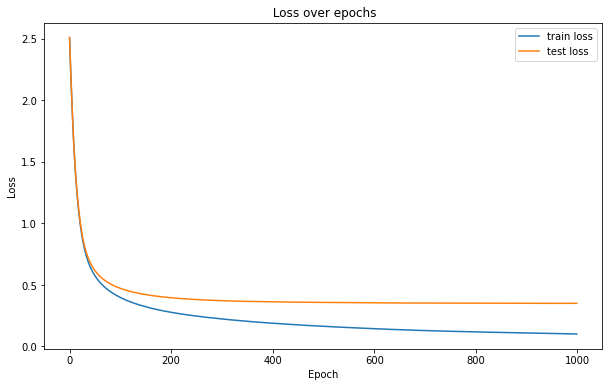

In [46]:
f.print_loss_by_epoch()